In [1]:
from lxml import etree
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns

import sys
sys.path.append('..\\helpers')

import cv2
import numpy as np
from tqdm import tqdm
import os
import csv
import uuid
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib 


Plotting more than one curve

In [2]:
def plot_roc_curves(positive_files, negative_files, colors, legends):
    plt.figure()

    for i in range(len(positive_files)):
        positive_file = positive_files[i]
        negative_file = negative_files[i]
        color = colors[i]
        legend = legends[i]

        # Read the positive sco file
        positive_data = pd.read_csv(positive_file, delimiter='\t', header=None, skiprows=1)
        positive_scores = positive_data.iloc[:, 1].values

        # Read the negative sco file
        negative_data = pd.read_csv(negative_file, delimiter='\t', header=None, skiprows=1)
        negative_scores = negative_data.iloc[:, 1].values

        # Combine positive and negative scores
        scores = np.concatenate((positive_scores, negative_scores))
        labels = np.concatenate((np.ones_like(positive_scores), np.zeros_like(negative_scores)))

        # Sort the scores in descending order
        sorted_indices = np.argsort(scores)[::-1]
        sorted_scores = scores[sorted_indices]
        sorted_labels = labels[sorted_indices]

        # Calculate sensitivity and average FPPI
        tpr = np.cumsum(sorted_labels) / np.sum(sorted_labels)
        fpr = np.cumsum(1 - sorted_labels) / len(negative_scores)

        # Calculate AUC
        auc = metrics.auc(fpr, tpr)

#         print(fpr)
        # print(tpr)
    
        # Define the file name
#         output_file = 'tpr_fpr.csv'

#         # Combine tpr and fpr arrays into a single array
#         data = np.vstack((tpr, fpr))

#         # Save data to CSV
#         with open(output_file, 'w', newline='') as file:
#             writer = csv.writer(file)
#             writer.writerows(data)

        # Plot the ROC curve
        plt.plot(fpr, tpr, linestyle='-', marker='o', color=color, linewidth=1, label=f'{legend} (AUC: {auc:.2f})')

        # plt.plot(fpr, tpr, marker='s', color=color, linewidth=1, label=f'{legend} (AUC: {auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ROC Curves')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

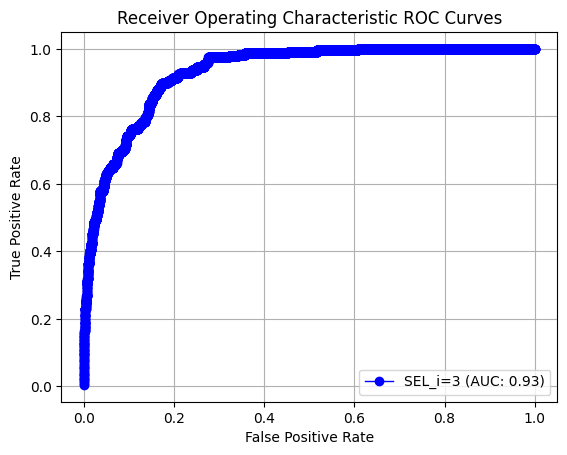

In [3]:
positive_files = ['../dataset/ml_runs/run4/SVM_SEL_3/10-fold-pos.SEL(003).sco', 
                #   '../dataset/ml_runs/run4/SVM_SEL_5/10-fold-pos.SEL(005).sco',
                #  '../dataset/ml_runs/run4/SVM_SEL_7/10-fold-pos.SEL(007).sco',
                #  '../dataset/ml_runs/run4/SVM_SEL_10/10-fold-pos.SEL(010).sco'
                 ]  # List of positive file paths

negative_files = ['../dataset/ml_runs/run4/SVM_SEL_3/10-fold-neg.SEL(003).sco', 
                #   '../dataset/ml_runs/run4/SVM_SEL_5/10-fold-neg.SEL(005).sco',
                #   '../dataset/ml_runs/run4/SVM_SEL_7/10-fold-neg.SEL(007).sco',
                #   '../dataset/ml_runs/run4/SVM_SEL_10/10-fold-neg.SEL(010).sco'
                  ]  # List of negative file paths

colors = ['blue', 'red', 'black', 'magenta']  # List of colors for each curve
legends = ['SEL_i=3', 'SEL_i=5', 'SEL_i=7', 'SEL_i=10']  # List of legends for each curve

plot_roc_curves(positive_files, negative_files, colors, legends)


negative_data.shape: (11419, 2)
negatives_candidates_fn.shape: (11419, 1)
positive_data.shape: (240, 2)
positive_candidates_fn.shape: (240, 1)


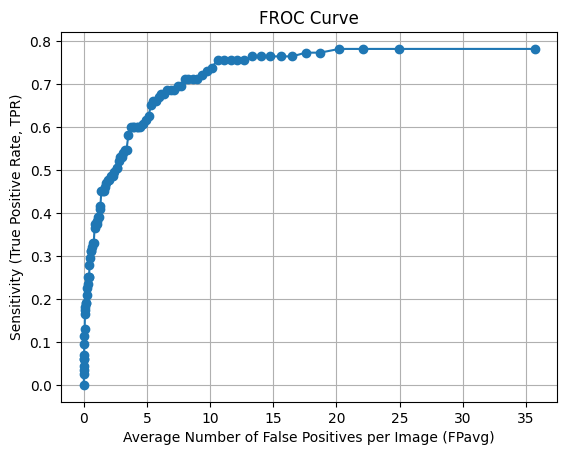

In [16]:
def count_above_threshold(df, threshold):
    return df[df['#SCORE'] > threshold]['image_id'].nunique()

def count_fp_above_threshold(df, threshold):
    return df[df['#SCORE'] > threshold].shape[0]

def build_froc_curve(df_positives, df_negatives,filenames_df_pos, filenames_df_neg, num_negative_imgs, num_true_masses, num_thresholds=100):

    scores_positives = df_positives['#SCORE']
    scores_negatives = df_negatives['#SCORE']

    filenames_df_pos = filenames_df_pos.iloc[:, 0:1].squeeze().reset_index(drop=True)
    filenames_df_neg = filenames_df_neg.iloc[:, 0:1].squeeze().reset_index(drop=True)

    # print(filenames_df_neg.isnull().values.any(), scores_positives.isnull().values.any())

    # indices_aligned = filenames_df_neg.index.equals(scores_negatives.index)
    # print(indices_aligned)

    combined_df_pos = pd.concat([filenames_df_pos, scores_positives], axis=1)
    combined_df_neg = pd.concat([filenames_df_neg, scores_negatives], axis=1)

    combined_df_pos = pd.concat([filenames_df_pos, scores_positives], axis=1)
    combined_df_neg = pd.concat([filenames_df_neg, scores_negatives], axis=1)

    score_columns = pd.concat([combined_df_pos['#SCORE'], combined_df_neg['#SCORE']])
    score_list = score_columns.tolist()


    # Calculate the number of true positive (TP) and false positive (FP) at different thresholds
    # thresholds = np.linspace(0, 1, num_thresholds)
    thresholds = np.linspace(min(score_list), max(score_list), num=num_thresholds)
    tp = np.zeros(num_thresholds)
    fp = np.zeros(num_thresholds)
    
    for i, threshold in enumerate(thresholds):

        tp[i] = count_above_threshold(combined_df_pos,threshold)
        # fp[i] = count_above_threshold(combined_df_neg, threshold)
        fp[i] = count_fp_above_threshold(combined_df_neg, threshold)

#     print(thresholds)
#     print(fp)
#     print(tp)

    # Calculate the sensitivity (TPR) and average number of false positives per image (FPavg)
    tpr = tp / num_true_masses
    fp_avg = fp / num_negative_imgs

    # Sort the vectors in ascending order of false positives
    sorted_indices = np.argsort(fp_avg)
    sorted_fp_avg = fp_avg[sorted_indices]
    sorted_tp = tp[sorted_indices]

    # Compute FROC AUC using the trapezoidal rule
    # froc_auc = np.trapz(sorted_tp, sorted_fp_avg)

#     print(fp_avg)
#     print(tpr)

    # Plot the FROC curve
    plt.plot(fp_avg, tpr, marker='o', label='FROC Curve')
    plt.xlabel('Average Number of False Positives per Image (FPavg)')
    plt.ylabel('Sensitivity (True Positive Rate, TPR)')
    plt.title('FROC Curve')
    plt.grid(True)
#     plt.xlim(0, 1)
    # plt.legend(['FROC Curve (AUC = {:.4f})'.format(froc_auc)])
    plt.show()


positive_files = ['../dataset/ml_runs/run4/SVM_SEL_3/10-fold-pos.SEL(003).sco', 
                  '../dataset/ml_runs/run4/SVM_SEL_5/10-fold-pos.SEL(005).sco',
                 '../dataset/ml_runs/run4/SVM_SEL_7/10-fold-pos.SEL(007).sco',
                 '../dataset/ml_runs/run4/SVM_SEL_10/10-fold-pos.SEL(010).sco']  # List of positive file paths

negative_files = ['../dataset/ml_runs/run4/SVM_SEL_3/10-fold-neg.SEL(003).sco', 
                  '../dataset/ml_runs/run4/SVM_SEL_5/10-fold-neg.SEL(005).sco',
                  '../dataset/ml_runs/run4/SVM_SEL_7/10-fold-neg.SEL(007).sco',
                  '../dataset/ml_runs/run4/SVM_SEL_10/10-fold-neg.SEL(010).sco']  # List of negative file paths


# positive_candidates_filenames = r'../dataset/output/features/output-99269090-de3c-4a01-8601-51a8fedd11e0-pos.csv'
positive_candidates_filenames = r'../dataset/output/features/final_run_4/image_id_pos.csv'
negatives_candidates_filenames = r'../dataset/output/features/final_run_4/image_id_neg.csv'

# Read the 
positive_candidates_fn = pd.read_csv(positive_candidates_filenames, delimiter='\t')
negatives_candidates_fn = pd.read_csv(negatives_candidates_filenames, delimiter='\t')

# Read the sco files
positive_data = pd.read_csv(positive_files[0], delimiter='\t')
negative_data = pd.read_csv(negative_files[0], delimiter='\t')

# Dropping the first 4,593 rows for the FP rows
# negative_data.drop(negative_data.index[:4593], inplace=True)
# negative_data.reset_index(drop=True, inplace=True)  # Reset the index

print("negative_data.shape: " + str(negative_data.shape))
print("negatives_candidates_fn.shape: " + str(negatives_candidates_fn.shape))
assert negative_data.shape[0] == negatives_candidates_fn.shape[0], "Check files, they should be same in shape[0]"

print("positive_data.shape: " + str(positive_data.shape))
print("positive_candidates_fn.shape: " + str(positive_candidates_fn.shape))
assert positive_data.shape[0] == positive_candidates_fn.shape[0], "Check files, they should be same in shape[0]"


# Add a column 'Labels' filled with zeros for the negative DataFrame
negative_data = negative_data.assign(Labels=0)

# Add a column 'Labels' filled with ones for the positive DataFrame
positive_data = positive_data.assign(Labels=1)

build_froc_curve(positive_data, negative_data, positive_candidates_fn, negatives_candidates_fn, num_negative_imgs=303, num_true_masses=115, num_thresholds=100)
